In [1]:
# Setting up functions
#-------------------------------------------------------------------------------

def build_first_order_markov_chain(transitions):
    """
    Creates a transition matrix based on the sequences of a treatment

    arguments:
    transitions: the trimmed to only contain the transitions sequences of a
    treatment

    returns:
    M: a matrix containing the normalized probabilities of the transitions
    """
    # Obtains the amount of sequences used for the average matrix
    amount_sequences = len(transitions)

    # Loops through the sequences and takes the unique states
    unique_states = set(state for sequence in transitions for state in sequence)

    # Number of unique states (3)
    n = len(unique_states)

    # Creates a index for each state (w:0, n:1, r:2)
    state_index = {state: index for index, state in enumerate(unique_states)}

    # Creates an matrix based on the number of unique states containing only 0
    M = [[0]*n for _ in range(n)]

    # Goes through each sequence and checks the current state with the next
    # state and adds 1 to the matrix based on the state index of the states
    # (0,1: W -> N)
    for sequence in transitions:
        for (i, j) in zip(sequence, sequence[1:]):
            M[state_index[i]][state_index[j]] += 1
    print("Total amount of transitions: ", M, "\n")


    # Sets empty list for the average transitions
    average_transitions = []

    # Creates another empty matrix
    average_M = [[0]*n for _ in range(n)]

    # Goes through the matrix and calculates the average number of transitions
    # per transition
    for outer_list in M:
      for inner_list in outer_list:
        average_transitions.append(inner_list / amount_sequences)

    # Turns the list into a 2d list and prints it
    average_transitions = [ round(elem, 2) for elem in average_transitions ]
    average_transitions_2d = [average_transitions[i:i+n] for i in range(0, len(average_transitions), n)]
    print(average_transitions_2d)

    # Normalizes the matrix
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    print("Normalized transition probabilities: ", M, "\n")

    return M, average_transitions_2d


def make_heatmap(transition_dict, title, state_labels):
    """
    This function makes the heatmap for the three treatment groups

    arguments:
    transition_dict: the transition dictionary containing the average
    transition probabilities for the sequences within the same treatment group
    title: the title of the heatmap depending on the treatment group that is
    being processed

    returns:
    heatmap: a heatmap showing the average transition probabilities per
    treatment group
    """
    # Creates an array of the transition dictionary
    transition_array = np.array(transition_dict)

    # Transpose the array to swap x-axis and y-axis, making it similair to the
    # Second-order heatmap
    transition_array = transition_array.T

    print("Generating heatmap\n")

    # Sets the colors for the heatmap
    colors = ["#FFEBEB", "#C74B4B"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)

    # Creates the heatmap
    plt.figure(figsize=(6, 5))
    heatmap = sns.heatmap(transition_array, annot=True, fmt=".2f",
                          cmap=cmap, cbar=True,linewidths=0.5, linecolor="white",
                          xticklabels=state_labels, yticklabels=state_labels)
    heatmap.set(xlabel="previous state", ylabel="next state")
    plt.title("Transition probability of the treatment: " + title)
    plt.show()


def average_transitions_heatmaps(transition_dict, title, state_labels):
    """
    This function makes the heatmap for the three treatment groups

    arguments:
    transition_dict: the transition dictionary containing the average
    transition probabilities for the sequences within the same treatment group
    title: the title of the heatmap depending on the treatment group that is
    being processed

    returns:
    heatmap: a heatmap showing the average transition probabilities per
    treatment group
    """
    # Creates an array of the transition dictionary
    transition_array = np.array(transition_dict)


    # Transpose the array to swap x-axis and y-axis, making it similair to the
    # Second-order heatmap
    transition_array = transition_array.T


    print("Generating heatmap\n")

    # Sets the colors for the heatmap
    colors = ["#FFEBEB", "#C74B4B"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)

    # Creates the heatmap
    plt.figure(figsize=(6, 5))
    heatmap = sns.heatmap(transition_array, annot=True, fmt=".2f",
                          cmap=cmap, cbar=True,linewidths=0.5, linecolor="white",
                          xticklabels=state_labels, yticklabels=state_labels)
    heatmap.set(xlabel="previous state", ylabel="next state")
    plt.title("Average number of transitions: " + title)
    plt.show()

def create_subgraph(name, prob, pos):
    """
    Generates the diGraph plots visualizing the transition probabilities between
    states.

    argument:
    name: the treatment name
    prob: the transition matrix for that treatment
    pos: positions for the nodes

    returns:
    dot: the diGraph plots for the treatment groups
    """
    # Creates a subgraph for the treatment probabilities
    with dot.subgraph(name=f"cluster_{name}") as sub:
        sub.attr(label=name, color="white", labelloc="t", labeljust="l")

        # Makes a node for each state with on the given positions
        for state in states:
            sub.node(f"{name}_{state}", label=state, shape="circle", style="filled",
                     fillcolor="white", fontcolor="black", fontsize="13!", fixedsize="true",
                     width="0.4", pos=pos[state])

        # Creates the edges between the nodes
        for i, value in enumerate(prob):
            for j, p in enumerate(value):
                if p > 0.01:
                    sub.edge(f"{name}_{states[i]}", f"{name}_{states[j]}", color="black",
                             penwidth=str(p), arrowsize="0.6", label=f"{p:.2f}", fontsize="10")

def difference_heatmaps(transitions_probabilities, state_labels):
    """
    Creates the heatmaps showing the difference in probabilities between
    RGS and control and CBD and control.

    arguments:
    transitions_probabilties: dictionary containing the probability matrix
    for each treatment

    returns:
    Two heatmaps showing the differences between the treatments
    """
    # Convert lists to numpy arrays for each treatment
    cbd_array = np.array(transitions_probabilities["CBD"])
    control_array = np.array(transitions_probabilities["Control"])
    rgs_array = np.array(transitions_probabilities["RGS"])

    # Calculate differences between rgs and control and cbd and control
    cbd_diff = cbd_array - control_array
    rgs_diff = rgs_array - control_array

    # Update the dictionary with the differences
    transitions_probabilities["CBD"] = cbd_diff.tolist()
    transitions_probabilities["RGS"] = rgs_diff.tolist()


    # Define custom colormap
    colors = ["#0000FF", "#FFFFFF", "#FF0000"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)

    # Checks the highest and lowest difference for the color segmentation
    # Set symmetric color range centered at 0
    max_diff = max(abs(cbd_diff).max(), abs(rgs_diff).max())
    vmin = -max_diff
    vmax = max_diff


    # Transpose the arrays to swap x-axis and y-axis, making it similair to the
    # second-order heatmap
    cbd_diff = cbd_diff.T
    rgs_diff = rgs_diff.T


    # Plot heatmaps
    plt.figure(figsize=(6, 5))
    heatmap = sns.heatmap(cbd_diff, annot=True, fmt=".2f", cmap=cmap,
                          cbar=True, linewidths=0.5, linecolor="white",
                          xticklabels=state_labels, yticklabels=state_labels,
                          vmin=vmin, vmax=vmax)
    heatmap.set(xlabel="previous state", ylabel="next state")
    plt.title("Difference CBD - Control")
    plt.show()

    plt.figure(figsize=(6, 5))
    heatmap = sns.heatmap(rgs_diff, annot=True, fmt=".2f", cmap=cmap,
                          cbar=True, linewidths=0.5, linecolor="white",
                          xticklabels=state_labels, yticklabels=state_labels,
                          vmin=vmin, vmax=vmax)
    heatmap.set(xlabel="previous state", ylabel="next state")
    plt.title("Difference RGS - Control")
    plt.show()


#Phasic tonic

    treatment  trial_num                                string_phasic_tonic
0     Control          3  [1, 2, 1, 2, 3, 4, 5, 4, 5, 4, 5, 4, 1, 2, 3, ...
1     Control          2  [1, 2, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 1, 2, 1, ...
2     Control          4  [1, 2, 3, 4, 2, 4, 5, 4, 5, 4, 2, 4, 5, 4, 1, ...
3     Control          5  [2, 3, 2, 3, 2, 4, 5, 4, 5, 4, 5, 4, 1, 2, 3, ...
4     Control          4  [1, 2, 1, 2, 3, 4, 5, 4, 5, 4, 1, 2, 3, 4, 1, ...
..        ...        ...                                                ...
383   Control          1  [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, ...
384   Control          4  [1, 2, 1, 2, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 1, ...
385   Control          2  [1, 2, 1, 2, 1, 2, 3, 1, 2, 3, 4, 5, 4, 5, 4, ...
386   Control          5  [1, 2, 3, 4, 2, 3, 2, 3, 2, 4, 5, 4, 5, 4, 5, ...
387   Control          3  [1, 2, 3, 4, 2, 3, 4, 5, 4, 5, 4, 5, 4, 1, 3, ...

[388 rows x 3 columns]
Next treatment is:  CBD
Total amount of transitions:  [[0, 502, 

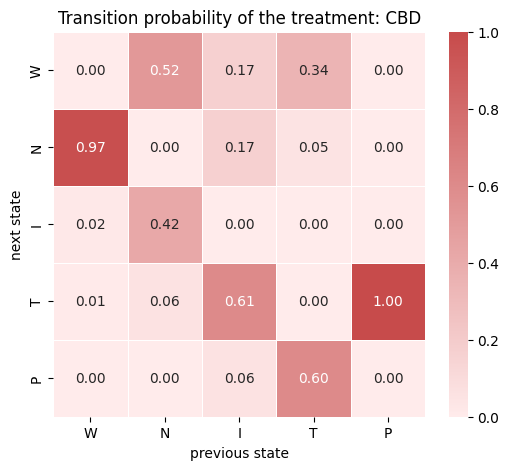

Generating heatmap



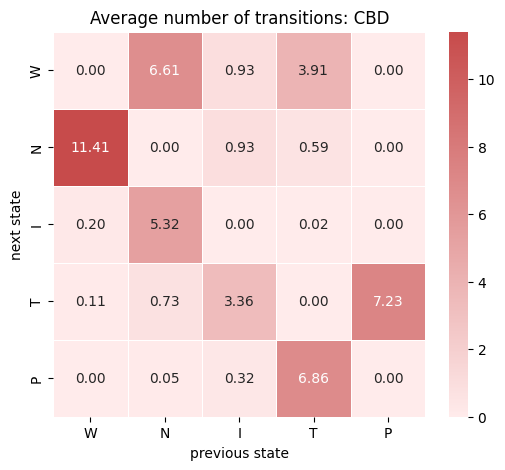


 
 

Next treatment is:  Control
Total amount of transitions:  [[0, 3880, 300, 42, 0], [2430, 0, 1384, 251, 5], [397, 189, 0, 1155, 36], [1307, 69, 96, 0, 2244], [0, 0, 0, 2285, 0]] 

[[0.0, 13.91, 1.08, 0.15, 0.0], [8.71, 0.0, 4.96, 0.9, 0.02], [1.42, 0.68, 0.0, 4.14, 0.13], [4.68, 0.25, 0.34, 0.0, 8.04], [0.0, 0.0, 0.0, 8.19, 0.0]]
Normalized transition probabilities:  [[0.0, 0.9189957366177167, 0.07105637138796779, 0.00994789199431549, 0.0], [0.597051597051597, 0.0, 0.34004914004914005, 0.06167076167076167, 0.0012285012285012285], [0.22341024198086662, 0.10635903207653348, 0.0, 0.6499718626899268, 0.020258863252673044], [0.3517222820236814, 0.018568353067814854, 0.02583423035522067, 0.0, 0.6038751345532831], [0.0, 0.0, 0.0, 1.0, 0.0]] 

Generating heatmap



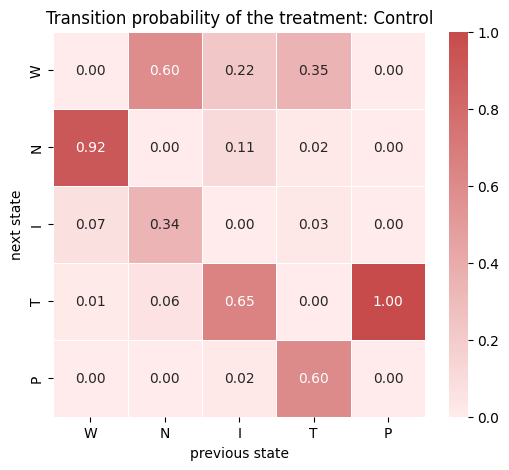

Generating heatmap



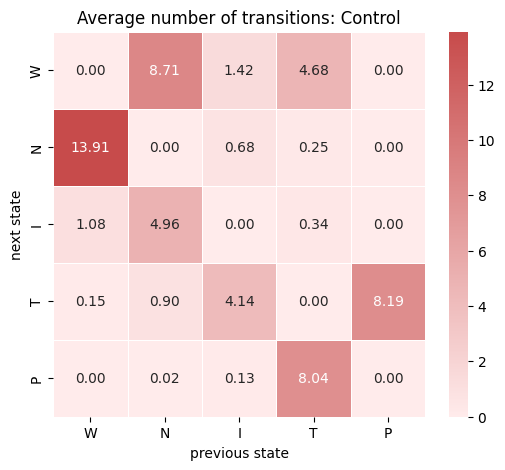


 
 

Next treatment is:  RGS
Total amount of transitions:  [[0, 1493, 19, 26, 0], [1037, 0, 388, 121, 4], [68, 68, 0, 272, 7], [410, 5, 8, 0, 523], [0, 0, 0, 534, 0]] 

[[0.0, 22.97, 0.29, 0.4, 0.0], [15.95, 0.0, 5.97, 1.86, 0.06], [1.05, 1.05, 0.0, 4.18, 0.11], [6.31, 0.08, 0.12, 0.0, 8.05], [0.0, 0.0, 0.0, 8.22, 0.0]]
Normalized transition probabilities:  [[0.0, 0.97074122236671, 0.01235370611183355, 0.016905071521456438, 0.0], [0.6690322580645162, 0.0, 0.2503225806451613, 0.07806451612903226, 0.0025806451612903226], [0.163855421686747, 0.163855421686747, 0.0, 0.655421686746988, 0.016867469879518072], [0.4334038054968288, 0.005285412262156448, 0.008456659619450317, 0.0, 0.5528541226215645], [0.0, 0.0, 0.0, 1.0, 0.0]] 

Generating heatmap



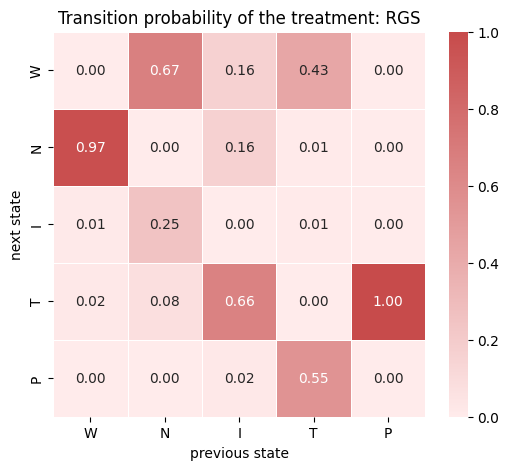

Generating heatmap



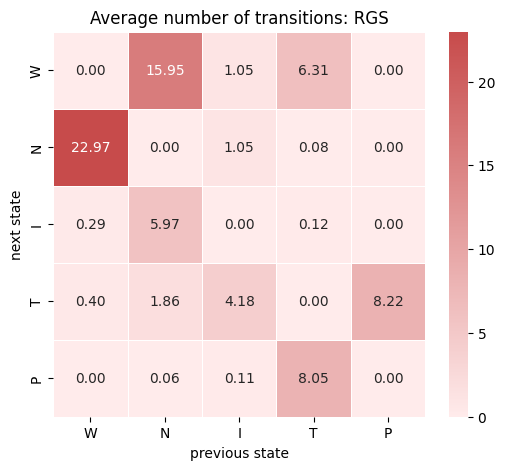


 
 

Generating transition graphs


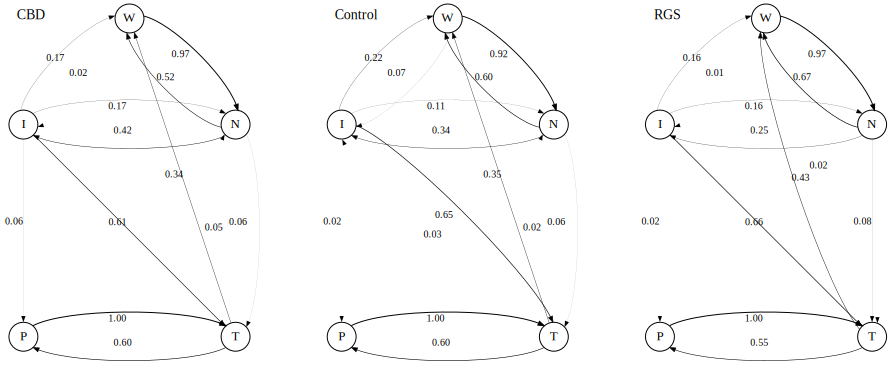



 Generating the probability difference heatmap



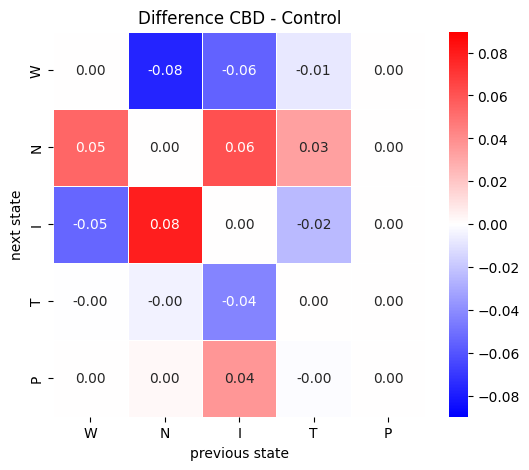

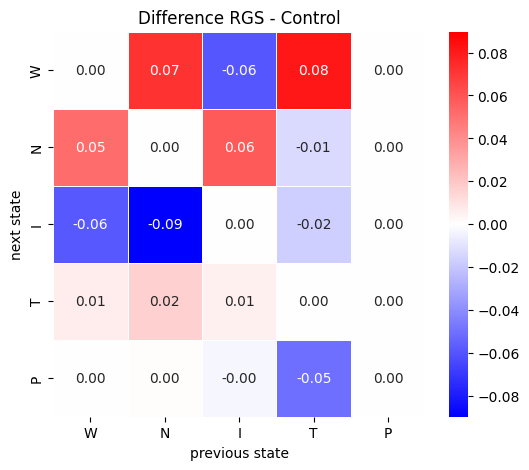



Generating the average difference heatmap



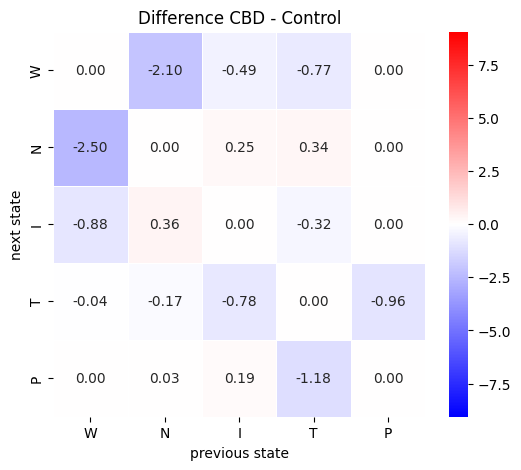

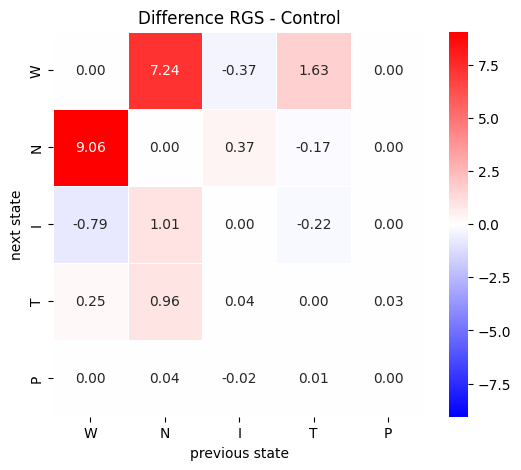

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from graphviz import Digraph
import seaborn as sns
import pandas as pd

# Data pre-processing
# ------------------------------------------------------------------------------
# This reads the file containing the sleep sequences and it turns it into a
# dataframe
file_path = "/content/string_analysis_hypno_latencies_tonic_phasic.xlsx"
df = pd.read_excel(file_path, sheet_name="Feuil1")


# dictionary containing the number that are in the file as keys and the
# corresponding treatment as the values
treatments = {0: "Control", 1: "CBD", 2: "Control", 3: "RGS", 4: "Control"}

# Replaces the numerical values of the treatments with the names
for row in df["treatment"]:
    df["treatment"] = df["treatment"].replace(row, treatments.get(row))

# Creates a dataframe with only the treatments, trial_num and sleep sequences
treat_trial_sequence_df = df[["treatment", "trial_num", "string_phasic_tonic"]]

def convert_sequence(sequence):
    """
    Function that makes the state names into numbers

    arguments:
    sequence: the sleep sequence containing the state abbreviations

    returns:
    numerical sleep sequence without any None values or consecutive states
    """

    # Checks if the current state is the same as the previous states, if so it
    # removes the current state and keeps the previous state
    filtered_sequence = [sequence[0]] + [sequence[i] for i in range(1, len(sequence)) if sequence[i] != sequence[i - 1]]

    # Changes the state abbreviations into corresponding numbers
    filtered_sequence = [1 if char == "W" else
                         2 if char == "N" else
                         3 if char == "I" else
                         4 if char == "T" else
                         5 if char == "P" else
                         1 if char == 1 else
                         2 if char == 2 else
                         3 if char == 3 else
                         4 if char == 4 else
                         5 if char == 5 else
                         None for char in filtered_sequence]

    return [state for state in filtered_sequence if state is not None]

# Applies the convert sequence function to the sleep sequence in the treat trial
# dataframe
treat_trial_sequence_df.loc[:, "string_phasic_tonic"] = treat_trial_sequence_df["string_phasic_tonic"].apply(convert_sequence)
treat_trial_sequence_df.loc[:, "string_phasic_tonic"] = treat_trial_sequence_df["string_phasic_tonic"].apply(convert_sequence)
print(treat_trial_sequence_df)

# Creates a dataframe grouped on the treatments and trial numbers
grouped_treatment_trial_sequences = treat_trial_sequence_df.groupby(["treatment", "trial_num"])["string_phasic_tonic"]

# Creates a dataframe grouped on the treatments
grouped_treatment = treat_trial_sequence_df.groupby(["treatment"])["string_phasic_tonic"]


# Processing the data
# ------------------------------------------------------------------------------
# Sets up new keys and and a empty dictionary for the transition probabilities
# Sets up the state names
new_keys = ["CBD", "Control", "RGS"]
states = ["W", "N", "I", "T", "P"]
transitions_probabilities = {}
average_number_of_transitions = {}

# Loops through the grouped dictionary and change the keys
for i, (key, item) in enumerate(grouped_treatment):
  print("Next treatment is: ", new_keys[i])
  new_key = new_keys[i]

  # Creates the transition matrix from the sequences
  matrix, average_matrix = build_first_order_markov_chain(item)

  # Creates the heatmap for the probabilities and uses the new key as the title
  make_heatmap(matrix, new_key, states)
  average_transitions_heatmaps(average_matrix, new_key, states)

  # Adds the newly made transition matrix to the dictionary with the new key as
  # the key
  transitions_probabilities[new_key] = matrix
  average_number_of_transitions[new_key] = average_matrix
  print("\n \n \n")

# Define the positions of the nodes
positions = {
    "CBD": {"P": "0,0!", "I": "0,1!", "N": "1,1!", "T": "1,0!", "W": "0.5,1.5!"},
    "Control": {"P": "1.5,0!", "I": "1.5,1!", "N": "2.5,1!", "T": "2.5,0!", "W": "2,1.5!"},
    "RGS": {"P": "3,0!", "I": "3,1!", "N": "4,1!", "T": "4,0!", "W": "3.5,1.5!"}
}

print("Generating transition graphs")


# Sets up the Digraph with consistent layout attributes
dot = Digraph(format="png", graph_attr={"nodesep": "0.9",
                                            "size": "13",
                                            "ratio": "expand"})
dot.attr(layout="neato")

# Calls the function that creates the transition graphs
create_subgraph("CBD", transitions_probabilities.get("CBD"), positions["CBD"])
create_subgraph("Control", transitions_probabilities.get("Control"), positions["Control"])
create_subgraph("RGS", transitions_probabilities.get("RGS"), positions["RGS"])

# Save the Digraph as a PNG file
dot.render(filename="Phasic_tonic_transition_prob_graph", format="pdf")
display(dot)

print("\n\n Generating the probability difference heatmap\n")
# Creates the difference heatmaps based on the transition dictionary
difference_heatmaps(transitions_probabilities, states)

print("\n\nGenerating the average difference heatmap\n")
# Creates the difference heatmaps based on the average dictionary
difference_heatmaps(average_number_of_transitions, states)

#REM

Next treatment is:  CBD
Total amount of transitions:  [[0, 503, 12], [328, 0, 191], [175, 26, 0]] 

[[0.0, 11.43, 0.27], [7.45, 0.0, 4.34], [3.98, 0.59, 0.0]]
Normalized transition probabilities:  [[0.0, 0.9766990291262136, 0.02330097087378641], [0.6319845857418112, 0.0, 0.36801541425818884], [0.8706467661691543, 0.12935323383084577, 0.0]] 

[[0.0, 11.43, 0.27], [7.45, 0.0, 4.34], [3.98, 0.59, 0.0]]
Generating heatmap



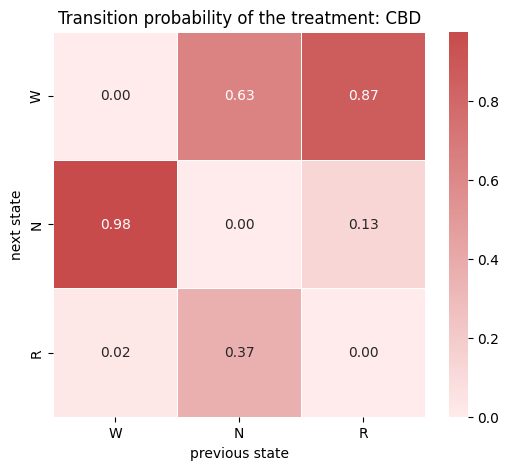

Generating heatmap



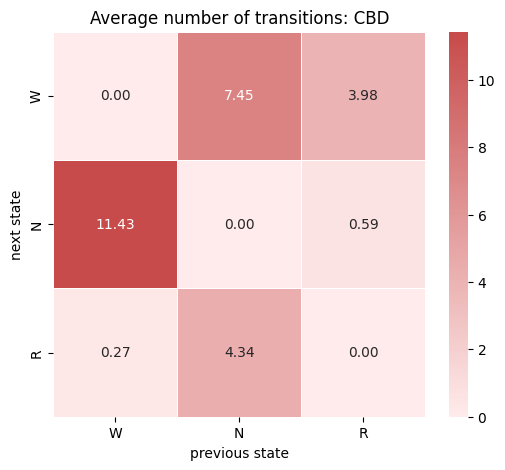


 
 

Next treatment is:  Control
Total amount of transitions:  [[0, 3911, 231], [2706, 0, 1232], [1348, 97, 0]] 

[[0.0, 14.02, 0.83], [9.7, 0.0, 4.42], [4.83, 0.35, 0.0]]
Normalized transition probabilities:  [[0.0, 0.9442298406566876, 0.05577015934331241], [0.6871508379888268, 0.0, 0.3128491620111732], [0.9328719723183391, 0.0671280276816609, 0.0]] 

[[0.0, 14.02, 0.83], [9.7, 0.0, 4.42], [4.83, 0.35, 0.0]]
Generating heatmap



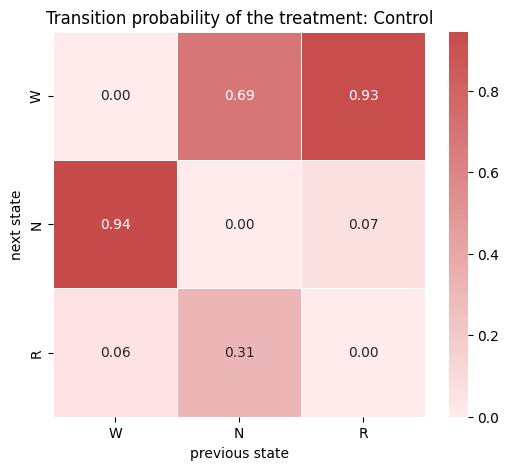

Generating heatmap



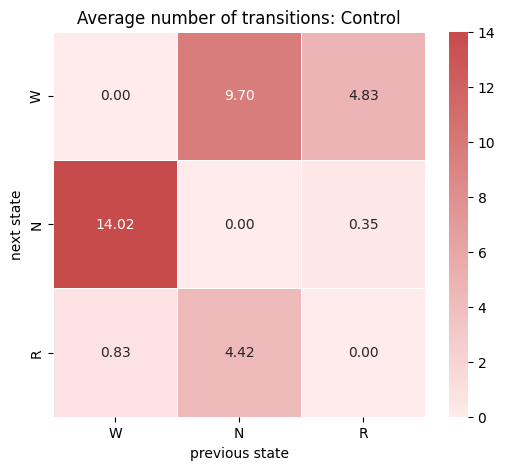


 
 

Next treatment is:  RGS
Total amount of transitions:  [[0, 1497, 37], [1094, 0, 393], [417, 6, 0]] 

[[0.0, 23.03, 0.57], [16.83, 0.0, 6.05], [6.42, 0.09, 0.0]]
Normalized transition probabilities:  [[0.0, 0.9758800521512386, 0.024119947848761408], [0.7357094821788837, 0.0, 0.26429051782111634], [0.9858156028368794, 0.014184397163120567, 0.0]] 

[[0.0, 23.03, 0.57], [16.83, 0.0, 6.05], [6.42, 0.09, 0.0]]
Generating heatmap



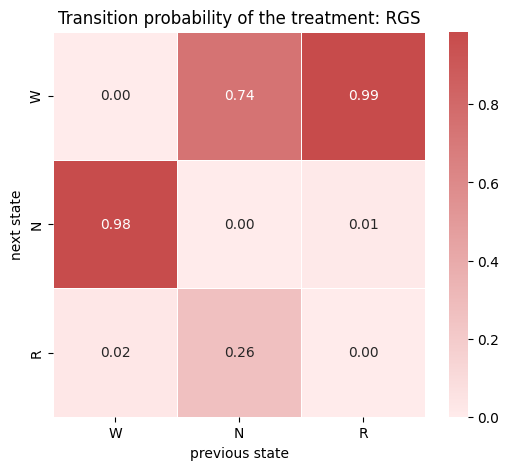

Generating heatmap



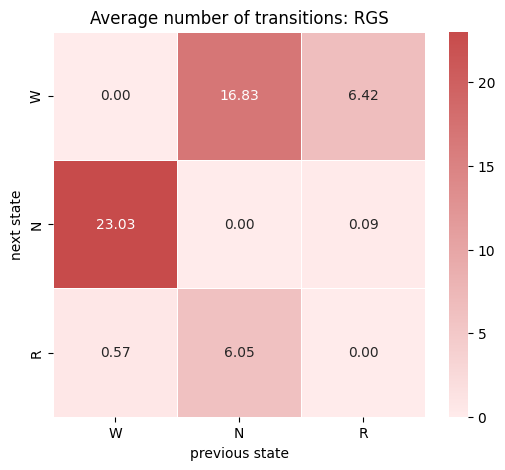


 
 

Generating transition graph 




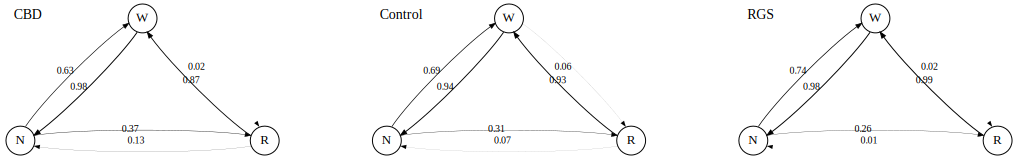



 Generating the probability difference heatmap



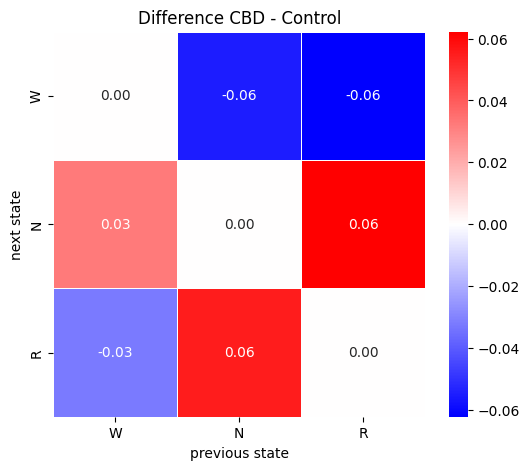

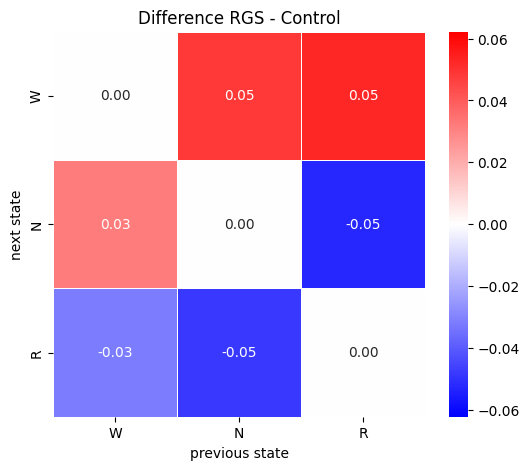



Generating the average difference heatmap



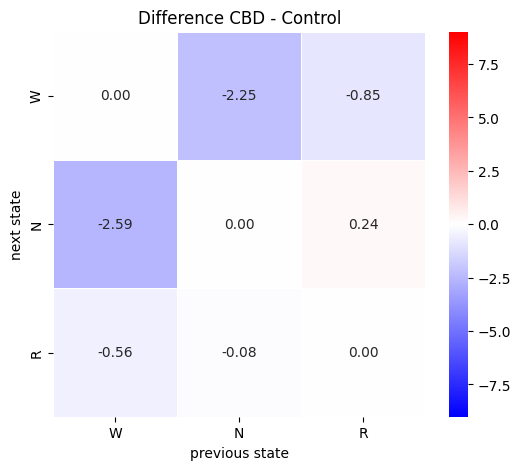

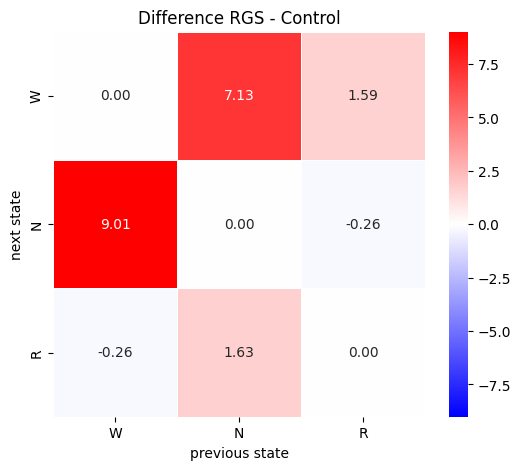

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from graphviz import Digraph
import seaborn as sns
import pandas as pd

# Data pre-processing
# ------------------------------------------------------------------------------
# This reads the file containing the sleep sequences and it turns it into a
# dataframe
file_path = "/content/string_analysis_hypno_latencies_tonic_phasic.xlsx"
df = pd.read_excel(file_path, sheet_name="Feuil1")


# dictionary containing the number that are in the file as keys and the
# corresponding treatment as the values
treatments = {0: "Control", 1: "CBD", 2: "Control", 3: "RGS", 4: "Control"}

# Replaces the numerical values of the treatments with the names
for row in df["treatment"]:
    df["treatment"] = df["treatment"].replace(row, treatments.get(row))


# Creates a dataframe with only the treatments, trial_num and sleep sequences
treat_trial_sequence_df = df[["treatment", "trial_num", "string_rem"]]

def convert_sequence(sequence):
    """
    Function that makes the state names into numbers

    arguments:
    sequence: the sleep sequence containing the state abbreviations

    returns:
    numerical sleep sequence without any None values or consecutive states
    """

    # Checks if the current state is the same as the previous states, if so it
    # removes the current state and keeps the previous state
    filtered_sequence = [sequence[0]] + [sequence[i] for i in range(1, len(sequence)) if sequence[i] != sequence[i - 1]]

    # Changes the state abbreviations into corresponding numbers
    filtered_sequence = [1 if char == "W" else
                         2 if char == "N" else
                         3 if char == "R" else
                         1 if char == 1 else
                         2 if char == 2 else
                         3 if char == 3 else
                         None for char in filtered_sequence]

    return [state for state in filtered_sequence if state is not None]

# Applies the convert sequence function to the sleep sequence in the treat trial
# dataframe
treat_trial_sequence_df.loc[:, "string_rem"] = treat_trial_sequence_df["string_rem"].apply(convert_sequence)
treat_trial_sequence_df.loc[:, "string_rem"] = treat_trial_sequence_df["string_rem"].apply(convert_sequence)

# Creates a dataframe grouped on the treatments and trial numbers
grouped_treatment_trial_sequences = treat_trial_sequence_df.groupby(["treatment", "trial_num"])["string_rem"]

# Creates a dataframe grouped on the treatments
grouped_treatment = treat_trial_sequence_df.groupby(["treatment"])["string_rem"]

# Processing the data
# ------------------------------------------------------------------------------
# Sets up new keys and and a empty dictionary for the transition probabilities
# Sets up the state names
new_keys = ["CBD", "Control", "RGS"]
states = ["W", "N", "R"]
transitions_probabilities = {}
average_number_of_transitions = {}

# Loops through the grouped dictionary
for i, (key, item) in enumerate(grouped_treatment):
  print("Next treatment is: ", new_keys[i])
  new_key = new_keys[i]

  # Creates the transition matrix from the sequences
  matrix, average_matrix = build_first_order_markov_chain(item)
  print(average_matrix)
  # Creates the heatmap for the probabilities and uses the new key as the title
  make_heatmap(matrix, new_key, states)
  average_transitions_heatmaps(average_matrix, new_key, states)

  # Adds the newly made transition matrix to the dictionary with the new key as
  # the key
  transitions_probabilities[new_key] = matrix
  average_number_of_transitions[new_key] = average_matrix
  print("\n \n \n")


print("Generating transition graph \n\n")
# Sets up the states and the position of the nodes
positions = {
    "CBD": {"N": "0,0!", "W": "0.5,0.5!", "R": "1,0!"},
    "Control": {"N": "1.5,0!", "W": "2.0,0.5!", "R": "2.5,0!"},
    "RGS": {"N": "3,0!", "W": "3.5,0.5!", "R": "4,0!"}
}

# Set up the digraph
dot = Digraph(format="png", graph_attr={"nodesep": "0.4", "size": "15", "ratio": "expand"})
dot.attr(layout="neato")

# Creates a subgraph for each treatment
create_subgraph("CBD", transitions_probabilities.get("CBD"), positions["CBD"])
create_subgraph("Control", transitions_probabilities.get("Control"), positions["Control"])
create_subgraph("RGS", transitions_probabilities.get("RGS"), positions["RGS"])


# Save the Digraph as a PNG file
dot.render(filename="string_rem_transition_prob_graph", format="pdf")

# Show the subgraph as one plot
display(dot)

print("\n\n Generating the probability difference heatmap\n")
# Creates the difference heatmaps based on the transition dictionary
difference_heatmaps(transitions_probabilities, states)

print("\n\nGenerating the average difference heatmap\n")
# Creates the difference heatmaps based on the average dictionary
difference_heatmaps(average_number_of_transitions, states)